In [1]:
import os

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt


import time

In [2]:
# class MusicClassifier(nn.Module):
#     def __init__(self, input_features, output_features):
#         super().__init__()
#         self.linear_layer_stack = nn.Sequential(
#             nn.Linear(
#                 in_features=input_features, out_features=2048, dtype=torch.float32
#             ),
#             nn.GELU(),
#             nn.Dropout(p=0.6),
#             nn.Linear(in_features=2048, out_features=1024, dtype=torch.float32),
#             nn.GELU(),
#             nn.Dropout(p=0.6),
#             nn.Linear(in_features=1024, out_features=512, dtype=torch.float32),
#             nn.GELU(),
#             nn.Dropout(p=0.6),
#             nn.Linear(in_features=512, out_features=256, dtype=torch.float32),
#             nn.GELU(),
#             nn.Dropout(p=0.6),
#             nn.Linear(in_features=256, out_features=128, dtype=torch.float32),
#             nn.GELU(),
#             nn.Dropout(p=0.6),
#             nn.Linear(in_features=128, out_features=64, dtype=torch.float32),
#             nn.GELU(),
#             nn.Dropout(p=0.6),
#             nn.Linear(
#                 in_features=64, out_features=output_features, dtype=torch.float32
#             ),
#         )

#     def forward(self, x):
#         return self.linear_layer_stack(x)

In [3]:
class MusicClassifier(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(
                in_features=input_features, out_features=256, dtype=torch.float32
            ),
            nn.GELU(),
            nn.Dropout(p=0.2),
            # nn.Linear(in_features=2048, out_features=1024, dtype=torch.float32),
            # nn.GELU(),
            # nn.Dropout(p=0.6),
            # nn.Linear(in_features=1024, out_features=512, dtype=torch.float32),
            # nn.GELU(),
            # nn.Dropout(p=0.6),
            # nn.Linear(in_features=512, out_features=256, dtype=torch.float32),
            # nn.GELU(),
            # nn.Dropout(p=0.6),
            # nn.Linear(in_features=256, out_features=128, dtype=torch.float32),
            # nn.GELU(),
            # nn.Dropout(p=0.6),
            nn.Linear(in_features=256, out_features=128, dtype=torch.float32),
            nn.GELU(),
            nn.Dropout(p=0.2),
            nn.Linear(
                in_features=128, out_features=output_features, dtype=torch.float32
            ),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [4]:
# Init le model
torch.manual_seed(42)
model = MusicClassifier(input_features=55, output_features=10)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.011)

def accuracy_fn(y_true, y_pred):
    correct = (
        torch.eq(input=y_true, other=y_pred).sum().item()
    )  # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100  # Calcul simple de pourcentage
    return acc

In [5]:
# Prepare data
df = pd.read_csv("./resources/actual_dataset.csv")
# df = pd.read_csv("/app/resources/original_dataset.csv")
X = torch.from_numpy(df.drop(columns=["label"]).to_numpy()).type(torch.float32)
y = torch.from_numpy(df["label"].to_numpy()).type(torch.long)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
# Training loop
torch.manual_seed(42)
epochs = 125

loss_history = []
acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(epochs):
    debut_time = time.time()
    """
    Train
    """
    model.train()

    # 1. Forward pass
    y_logits = model(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Metrics
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 2.1 Save metrics
    loss_history.append(loss.cpu().detach().numpy())
    acc_history.append(acc)

    # 3. Zero Grad
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Optimmizer step
    optimizer.step()

    """
    Test
    """
    model.eval()

    with torch.inference_mode():
        # 1. Forward pass
        y_test_logits = model(X_test)
        y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

        # 2. Metrics
        test_loss = loss_fn(y_test_logits, y_test)
        test_acc = accuracy_fn(y_pred=y_test_pred, y_true=y_test)

        # 2.1 Save metrics
        test_loss_history.append(test_loss.cpu().detach().numpy())
        test_acc_history.append(test_acc)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
        print(f"one epoch duration: {time.time() - debut_time}")

Epoch: 0 | Loss: 2.29018, Acc: 12.28% | Test Loss: 1.87097, Test Acc: 37.68%
one epoch duration: 0.07394266128540039
Epoch: 10 | Loss: 1.00499, Acc: 63.62% | Test Loss: 0.94677, Test Acc: 67.32%
one epoch duration: 0.0409395694732666
Epoch: 20 | Loss: 0.69239, Acc: 75.99% | Test Loss: 0.70567, Test Acc: 76.11%
one epoch duration: 0.04145646095275879
Epoch: 30 | Loss: 0.52385, Acc: 81.55% | Test Loss: 0.59425, Test Acc: 80.16%
one epoch duration: 0.0323178768157959
Epoch: 40 | Loss: 0.39675, Acc: 86.11% | Test Loss: 0.50925, Test Acc: 83.61%
one epoch duration: 0.03511476516723633
Epoch: 50 | Loss: 0.31058, Acc: 89.05% | Test Loss: 0.44883, Test Acc: 86.01%
one epoch duration: 0.03396463394165039
Epoch: 60 | Loss: 0.23781, Acc: 92.05% | Test Loss: 0.42084, Test Acc: 87.26%
one epoch duration: 0.03633928298950195
Epoch: 70 | Loss: 0.17976, Acc: 93.77% | Test Loss: 0.40732, Test Acc: 88.31%
one epoch duration: 0.03497910499572754
Epoch: 80 | Loss: 0.15192, Acc: 95.10% | Test Loss: 0.38610

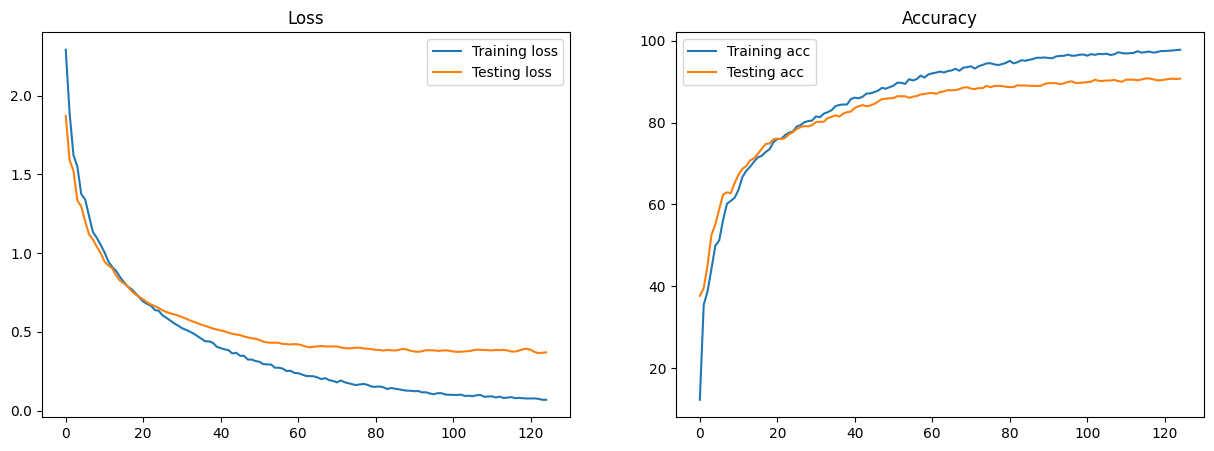

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(epochs), loss_history, label="Training loss")
plt.plot(range(epochs), test_loss_history, label="Testing loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(range(epochs), acc_history, label="Training acc")
plt.plot(range(epochs), test_acc_history, label="Testing acc")
plt.legend()
plt.title("Accuracy")

plt.show()

In [9]:
# Save the model

# torch.save(obj=model.state_dict(), f="./resources/original_model_fast.pth")